# 09. Milestone Project 2: SkimLit 📄🔥

We're going to be replicating the deep learning model behind the 2017 paper [*PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071).

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled **Randomized Controlled Trial** (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

![Skimlit example inputs and outputs](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-skimlit-overview-input-and-output.png)

*Example inputs ([harder to read abstract from PubMed](https://pubmed.ncbi.nlm.nih.gov/28942748/)) and outputs ([easier to read abstract](https://pubmed.ncbi.nlm.nih.gov/32537182/)) of the model we're going to build. The model will take an abstract wall of text and predict the section label each sentence should have.*  

### Model Input

For example, can we train an NLP model which takes the following input (note: the following sample has had all numerical symbols replaced with "@"):

> To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ). A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks. Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers. Pain was assessed using the visual analog pain scale ( @-@ mm ).
Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ).,
Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured.
There was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks. The mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively. Further , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group. These differences remained significant at @ weeks. The Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ). Low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ).

### Model output

And returns the following output:

```
['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .\n',
 'RESULTS\tThere was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks .\n',
 'RESULTS\tThe mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively .\n',
 'RESULTS\tFurther , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group .\n',
 'RESULTS\tThese differences remained significant at @ weeks .\n',
 'RESULTS\tThe Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .\n',
 'CONCLUSIONS\tLow-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ) .\n',
 '\n']
 ```


## What we're going to cover

* Downloading a text dataset ([PubMed RCT200k from GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
* Writing a preprocessing function to prepare our data for modelling
* Setting up a series of modelling experiments
  * Making a baseline (TF-IDF classifier)
  * Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
* Building multimodal model (taking multiple types of data inputs)
  * Replicating the model architecture from https://arxiv.org/pdf/1612.05251.pdf 
* Find the most wrong predictions
* Making predictions on PubMed abstracts from the wild

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f945b307-43de-2280-bec3-7f04e550ab5b)


## Get data

Download the PubMed 200k RCT dataset.
txt files [on GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).

We can copy them to our local directory using `git clone https://github.com/Franck-Dernoncourt/pubmed-rct`.

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 3.10 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Looking at the [README file](https://github.com/Franck-Dernoncourt/pubmed-rct) from the GitHub page, we get the following information:
* PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
* `PubMed_200k_RCT` is the same as `PubMed_200k_RCT_numbers_replaced_with_at_sign`, except that in the latter all numbers had been replaced by `@`. (same for `PubMed_20k_RCT` vs. `PubMed_20k_RCT_numbers_replaced_with_at_sign`).
* Since Github file size limit is 100 MiB, we had to compress `PubMed_200k_RCT\train.7z` and `PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip`. To uncompress `train.7z`, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.

To begin with, the dataset we're going to be focused on is `PubMed_20k_RCT_numbers_replaced_with_at_sign`.

Why this one?

Rather than working with the whole 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could've chosen the dataset with numbers instead of having them replaced with `@` but we didn't.

In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


Beautiful, looks like we've got three separate text files:
* `train.txt` - training samples.
* `dev.txt` - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).
* `test.txt` - test samples.

To save ourselves typing out the filepath to our target directory each time, let's turn it into a variable.

In [4]:
from pathlib import Path

data_dir = Path.cwd() / "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = {f.stem:f for f in data_dir.glob("*")}
filenames

{'test': PosixPath('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'),
 'dev': PosixPath('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt'),
 'train': PosixPath('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')}

## Preprocess data : Visualize the data

In [5]:
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [6]:
get_lines(filenames["train"])[:16]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
train_lines = get_lines(filenames["train"])

The role of each sentence is prefixed at the start of each line separated by a tab (`\t`) and each sentence finishes with a new line (`\n`).

Different abstracts are separated by abstract ID's (lines beginning with `###`) and newlines (`\n`).

Knowing this, it looks like we've got a couple of steps to do to get our samples ready to pass as training data to our future machine learning model.

Let's write a function to perform the following steps:
* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:  
  * If the line begins with `###` mark it as an abstract ID and the beginning of a new abstract.
    * Keep count of the number of lines in a sample.
  * If the line begins with `\n` mark it as the end of an abstract sample.
    * Keep count of the total lines in a sample.
  * Record the text before the `\t` as the label of the line.
  * Record the text after the `\t` as the text of the line.
* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  * `"line_number"` - the position of the line in the abstract (e.g. `3`).
  * `"target"` - the role of the line in the abstract (e.g. `OBJECTIVE`).
  * `"text"` - the text of the line in the abstract.
  * `"total_lines"` - the total lines in an abstract sample (e.g. `14`).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.

Example returned preprocessed sample (a single line from an abstract):

```
[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  "line_number": 0,
  'total_lines': 11},
  ...]
```

In [8]:
'\n'.isspace()

True

In [9]:
def preprocess_text(filename):

  input_lines = get_lines(filename) 
  abstract_lines = "" # will contain the text 
  abstract_samples = [] 
  

  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_lines = "" 
    elif line.isspace(): # check to see if line is a new line : ie "\n" => abstract_lines is complete
      abstract_line_split = abstract_lines.splitlines() # split on "\n"

      for i, text in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = text.split("\t") # e.g : line = 'OBJECTIVE\tTo investigate the efficacy [...] ( OA ) .\n' 
        line_data["target"] = target_text_split[0] 
        line_data["text"] = target_text_split[1].lower() 
        line_data["line_number"] = i # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) 
        abstract_samples.append(line_data) 
    
    else: 
      abstract_lines += line
  
  return abstract_samples

In [10]:
train_samples = preprocess_text(filenames["train"])
val_samples = preprocess_text(filenames["dev"]) # dev (aka development) is another name for validation set
test_samples = preprocess_text(filenames["test"])
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
train_samples[0]

{'target': 'OBJECTIVE',
 'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'line_number': 0,
 'total_lines': 12}

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


In [13]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

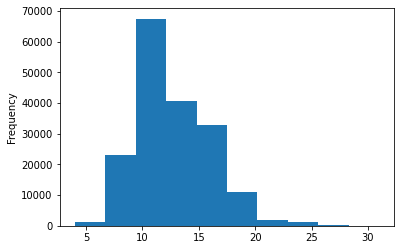

In [14]:
train_df.total_lines.plot.hist()

looks like most of the abstracts are around 7 to 15 sentences in length.

**Features**

In [15]:
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

In [16]:
train_sentences[:train_df.total_lines[0]]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

We're going to create one_hot and label_encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) classes.

> **Reminder :**
<br><br>
 If your 𝑌𝑖
's are one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): <br> [1,0,0] , [0,1,0], [0,0,1] 
<br>
<br>
But if your 𝑌𝑖
's are integers, use sparse_categorical_crossentropy. Examples for above 3-class classification problem: <br> [1] , [2], [3]

In [17]:
train_df.target.to_numpy().reshape(-1, 1)

array([['OBJECTIVE'],
       ['METHODS'],
       ['METHODS'],
       ...,
       ['RESULTS'],
       ['CONCLUSIONS'],
       ['CONCLUSIONS']], dtype=object)

In [18]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
num_classes = len(label_encoder.classes_)
class_name = label_encoder.classes_

num_classes, class_name

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [21]:
label_encoder.classes_ == one_hot_encoder.categories_

array([[ True,  True,  True,  True,  True]])

## Model 0: Getting a baseline 

Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

To build it, we'll create a Scikit-Learn `Pipeline` which uses the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) aglorithm.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded) # train_labels_one_hot doesn't work

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [24]:
baseline_preds = model_0.predict(val_sentences)

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    scores = {
        "accuracy":acc,
        "precision":precision,
        "recall":recall,
        "f1_score":f1
    }
    return scores

In [26]:
baseline_scores = evaluate(val_labels_encoded, baseline_preds)
baseline_scores

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

## Preparing our data for deep sequence models

Excellent! We've got a working baseline to try and improve upon.

But before we start building deeper models, we've got to create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
sentences_length = [len(sentences.split()) for sentences in train_sentences]
avg_length = np.mean(sentences_length)
avg_length # average words in a sentence
# see better on an histogram

26.338269273494777

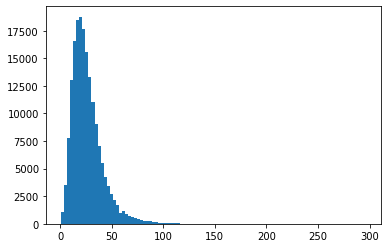

In [29]:
import matplotlib.pyplot as plt 

plt.hist(sentences_length, bins=100);
# most of the sentences are between 0 and 50 word

We can use NumPy's [`percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) to find the value which covers 95% of the sentence lengths.

In [30]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sentences_length, 95))
output_seq_len 

55

### Create text vectorizer

We'll use the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer from TensorFlow.

We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

Section 3.2 of the [PubMed 200k RCT paper](https://arxiv.org/pdf/1710.06071.pdf) states the **vocabulary size of the PubMed 20k dataset as 68,000**. So we'll use that as our `max_tokens` parameter.

In [31]:
max_tokens = 68_000

In [32]:
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens, # number of words in vocabulary : 68_000
                                           output_sequence_length=output_seq_len) # desired output length of vectorized sequences : 55

In [33]:
text_vectorizer.adapt(train_sentences)

In [34]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### Create custom text embedding

To create a richer numerical representation of our text, we can use an [**`tf.keras.layers.Embedding`**](https://www.tensorflow.org/tutorials/text/word_embeddings) layer.<br>
As our model learns, it'll update its embedding to better represent the relationships between tokens in our corpus.<br><br>

Once again, the main parameters we're concerned with here are the inputs and outputs of our `Embedding` layer.

The `input_dim` parameter defines the size of our vocabulary. And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size `output_dim`.

In [35]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # Use masking to handle variable sequence lengths (save space)
                               name="token_embedding")

In [36]:
sentence = np.random.choice(train_sentences)
vectorized_sentence = text_vectorizer([sentence]) # without list also work
embedded_sentence = token_embed(vectorized_sentence)

print(f"Sentence before vectorization:\n{sentence}\n")
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
there was no difference observed during the study in the incidence of nonfatal mi , nonfatal stroke , death , rehospitalisation or need for urgent revascularisation due to a cardiac event between prasugrel and clopidogrel .

Sentence after vectorization (before embedding):
[[   61    10    33    74   148    52     2    17     5     2   214     4
   2718  1180  2718   276   339 16650    16   483    11  4132  6150   434
      6     8   342   675    30  3233     3  1255     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.04966047  0.04938657 -0.0028399  ...  0.0067886  -0.04072024
    0.02645757]
  [-0.04236146  0.02656391  0.04449571 ... -0.00832828  0.04336642
    0.04254491]
  [-0.04503232  0.01749355 -0.00933626 ... -0.01151789 -0.01350446
   -0.02778645]
  ...
  [ 0.02477193 -0.04053049 -0.03133355 ... -0.03747075  0.01648692
    

## Create datasets (as fast as possible)

The `tf.data` API provides methods which enable faster data loading.

> 📖 **Resource:** For best practices on data loading in TensorFlow, check out the following:
* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)


To create a batched `PrefetchDataset` we can use the methods [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), the parameter [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

> **Reminder :** <br>
When training machine learning models, the input data is often read from disk and processed in batches. The prefetch() method allows you to specify how many batches to prefetch ahead of the current batch, so that the next batch is ready to be processed as soon as the current batch is finished (call : **prefetching batches**).
<br>
The prefetch() method can be used with TensorFlow's Dataset class, and the number of elements to prefetch can be specified as an argument to the method. For example:
<br>
```
dataset = ...  # create a TensorFlow dataset
dataset = dataset.prefetch(buffer_size=10)
```
In this example, buffer_size=10 specifies that TensorFlow should prefetch 10 batches of data ahead of the current batch.

### Batch

The batch size is a hyperparameter that determines the number of samples that are processed before the model parameters are updated. The batch size affects the model training in several ways, including the stability of the training process, the speed of convergence, and the use of memory.

In general, smaller batch sizes result in more frequent updates of the model parameters, which can lead to more stability in the training process but slower convergence. Larger batch sizes can lead to faster convergence but less stability in the training process.

In practice, a batch size of 32 or 64 is a good starting point for most problems

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [38]:
train_dataset_bis = train_dataset.batch(200).prefetch(tf.data.AUTOTUNE)
val_dataset_bis = val_dataset.batch(200).prefetch(tf.data.AUTOTUNE)
test_dataset_bis = test_dataset.batch(200).prefetch(tf.data.AUTOTUNE)

In [39]:
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D with token embeddings


All of our deep models will follow a similar structure:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main component we'll be changing throughout is the `Layers` component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network. 

We're also going to be following the standard machine learning workflow of:
- Build model
- Train model
- Evaluate model (make predictions and compare to ground truth)


In [40]:
tf.random.set_seed(0)

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding="same",
                  activation="relu",)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [41]:
history_1 = model_1.fit(train_dataset,
                        epochs=3,
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset )))

Epoch 1/3
2814/2814 [==============================] - 31s 9ms/step - loss: 0.6347 - accuracy: 0.7682 - val_loss: 0.5421 - val_accuracy: 0.8039
Epoch 2/3
2814/2814 [==============================] - 23s 8ms/step - loss: 0.4606 - accuracy: 0.8393 - val_loss: 0.5416 - val_accuracy: 0.8065
Epoch 3/3
2814/2814 [==============================] - 23s 8ms/step - loss: 0.3808 - accuracy: 0.8693 - val_loss: 0.5727 - val_accuracy: 0.7982


In [42]:
preds_1 = np.argmax(model_1.predict(test_dataset), axis=1)

471/471 [==============================] - 1s 2ms/step


In [43]:
scores_1 = evaluate(test_labels_encoded, preds_1)
scores_1

{'accuracy': 0.7967479674796748,
 'precision': 0.7934215611974321,
 'recall': 0.7967479674796748,
 'f1_score': 0.7943843600330328}

In [44]:
# Create a helper function to compare our baseline results to new model results
def compare_to_baseline(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, {'New '+key:->20}: {new_model_results[key]:.2f}, {'Difference':->15}: {(new_model_results[key]-value)*100:.2f}%")

In [45]:
compare_to_baseline(baseline_scores, scores_1)

Baseline accuracy: 0.72, --------New accuracy: 0.80, -----Difference: 7.49%
Baseline precision: 0.72, -------New precision: 0.79, -----Difference: 7.48%
Baseline recall: 0.72, ----------New recall: 0.80, -----Difference: 7.49%
Baseline f1_score: 0.70, --------New f1_score: 0.79, -----Difference: 9.55%


In [46]:
# Try with larger batch
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, 
                               mask_zero=True, 
                               name="token_embedding")(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding="same",
                  activation="relu",)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1_bis = tf.keras.Model(inputs, outputs)

model_1_bis.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1_bis = model_1_bis.fit(train_dataset_bis,
                        epochs=3,
                        validation_data=val_dataset_bis,
                        validation_steps=int(0.1*len(val_dataset_bis)))

Epoch 1/3
901/901 [==============================] - 9s 9ms/step - loss: 0.7113 - accuracy: 0.7348 - val_loss: 0.5677 - val_accuracy: 0.7963
Epoch 2/3
901/901 [==============================] - 9s 10ms/step - loss: 0.4890 - accuracy: 0.8287 - val_loss: 0.5631 - val_accuracy: 0.8013
Epoch 3/3
901/901 [==============================] - 8s 9ms/step - loss: 0.4119 - accuracy: 0.8592 - val_loss: 0.5931 - val_accuracy: 0.7903


## Model 2: Feature extraction with pretrained token embeddings

Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it mentions they used a [pretrained GloVe embedding](https://nlp.stanford.edu/projects/glove/) as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4).

> 🔑 **Note:** We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save [using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/) as an extension.

The model structure will look like:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, **feature extraction transfer learning**. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

<br>

To download the pretrained USE into a layer we can use in our model, we can use the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

We'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

> 🔑 **Note:** Due to having to download a relatively large model (~916MB), the cell below may take a little while to run.

In [47]:
import tensorflow_hub as hub 

hub_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [48]:
inputs = layers.Input(shape=[], dtype="string") 
# inputs has to be a list for 'hub_embeddeing' layer => according to https://tfhub.dev/google/universal-sentence-encoder/4
x = hub_embedding(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [49]:
history_2 = model_2.fit(train_dataset_bis, 
                        epochs=3,
                        validation_data=val_dataset_bis,
                        validation_steps=int(0.1*len(val_dataset_bis)))

Epoch 1/3
901/901 [==============================] - 26s 25ms/step - loss: 0.8056 - accuracy: 0.6914 - val_loss: 0.7185 - val_accuracy: 0.7227
Epoch 2/3
901/901 [==============================] - 23s 26ms/step - loss: 0.6957 - accuracy: 0.7345 - val_loss: 0.6640 - val_accuracy: 0.7507
Epoch 3/3
901/901 [==============================] - 21s 24ms/step - loss: 0.6546 - accuracy: 0.7517 - val_loss: 0.6382 - val_accuracy: 0.7590


In [50]:
preds_2 = np.argmax(model_2.predict(test_dataset_bis), axis=1)

151/151 [==============================] - 4s 22ms/step


In [51]:
scores_2 = evaluate(test_labels_encoded, preds_2)
compare_to_baseline(baseline_scores, scores_2)

Baseline accuracy: 0.72, --------New accuracy: 0.75, -----Difference: 2.67%
Baseline precision: 0.72, -------New precision: 0.75, -----Difference: 2.67%
Baseline recall: 0.72, ----------New recall: 0.75, -----Difference: 2.67%
Baseline f1_score: 0.70, --------New f1_score: 0.74, -----Difference: 4.55%


## Creating a character-level tokenizer

The [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) paper mentions their model uses a hybrid of token and character embeddings.

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g. `hello` -> [`h`, `e`, `l`, `l`, `o`]) where as a **token embedding** is created on sequences split into tokens.

![example of difference between token level and character level embeddings](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-token-vs-character-embeddings.png)


We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) class and then passing those vectorized sequences through an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [52]:
list("hello world")

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd']

In [53]:
def split_chars(text):
    return " ".join(list(text))

split_chars(sentence)

't h e r e   w a s   n o   d i f f e r e n c e   o b s e r v e d   d u r i n g   t h e   s t u d y   i n   t h e   i n c i d e n c e   o f   n o n f a t a l   m i   ,   n o n f a t a l   s t r o k e   ,   d e a t h   ,   r e h o s p i t a l i s a t i o n   o r   n e e d   f o r   u r g e n t   r e v a s c u l a r i s a t i o n   d u e   t o   a   c a r d i a c   e v e n t   b e t w e e n   p r a s u g r e l   a n d   c l o p i d o g r e l   .'

In [54]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [55]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

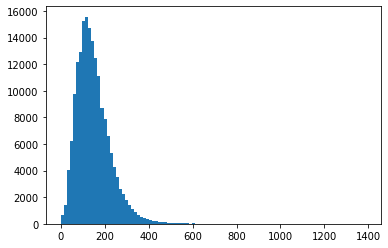

In [56]:
plt.hist(char_lens, bins=100);

In [57]:
output_seq_char_len = int(np.percentile(char_lens, 95)) #cover 95% of chars in avg sentence
output_seq_char_len

290

We'll set max_tokens (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens + digit + punctuation.

In [58]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation 
len(alphabet)

68

In [59]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [60]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Creating a character-level embedding

Just like our custom token embedding, we can do so using the [`tensorflow.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) class.


The input dimension (`input_dim`) will be equal to the number of different characters in our `char_vocab` (28). And since we're following the structure of the model in Figure 1 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), the output dimension of the character embedding (`output_dim`) will be 25.

In [61]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

### Building a Conv1D model to fit on character embeddings

```
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)
```


In [62]:
inputs = layers.Input(shape=(1,), dtype="string")
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64, 5,
                  padding="same",
                  activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 5)                 325 

In [63]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE) # more accurate
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset_bis = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(200).prefetch(tf.data.AUTOTUNE) # faster
val_char_dataset_bis = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(200).prefetch(tf.data.AUTOTUNE)
test_char_dataset_bis = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(200).prefetch(tf.data.AUTOTUNE)

In [64]:
history_3 = model_3.fit(train_char_dataset_bis,
                        epochs=3,
                        validation_data=val_char_dataset_bis,
                        validation_steps=int(0.1 * len(val_char_dataset_bis)))

Epoch 1/3
901/901 [==============================] - 9s 9ms/step - loss: 1.3732 - accuracy: 0.4119 - val_loss: 1.3045 - val_accuracy: 0.4633
Epoch 2/3
901/901 [==============================] - 8s 9ms/step - loss: 1.2821 - accuracy: 0.4664 - val_loss: 1.2667 - val_accuracy: 0.4763
Epoch 3/3
901/901 [==============================] - 10s 12ms/step - loss: 1.2509 - accuracy: 0.4816 - val_loss: 1.2315 - val_accuracy: 0.4937


In [65]:
preds_3 = np.argmax(model_3.predict(test_dataset_bis), axis=1)

151/151 [==============================] - 1s 4ms/step


In [66]:
scores_3 = evaluate(test_labels_encoded, preds_3)
compare_to_baseline(baseline_scores, scores_3)

Baseline accuracy: 0.72, --------New accuracy: 0.37, -----Difference: -35.37%
Baseline precision: 0.72, -------New precision: 0.24, -----Difference: -47.60%
Baseline recall: 0.72, ----------New recall: 0.37, -----Difference: -35.37%
Baseline f1_score: 0.70, --------New f1_score: 0.26, -----Difference: -43.57%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

To start replicating the model in Figure 1, we're going to go through the following steps:
1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Combine using [**`layers.Concatenate`**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [67]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
x = hub_embedding(token_inputs)
token_outputs = layers.Dense(128, activation="relu", name="token_output")(x)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
x = char_vectorizer(char_inputs)
x = char_embed(x)
char_outputs = layers.Bidirectional(layers.LSTM(25), name="char_outputs")(x)
char_model = tf.keras.Model(char_inputs, char_outputs, name="char_model")

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
x = layers.Dropout(0.5)(token_char_concat)
x = layers.Dense(200, activation="relu")(x)
final_outputs = layers.Dense(num_classes, activation="softmax", name="final_output")(x)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model([token_model.input, char_model.input],
                         final_outputs)

In [68]:
model_4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']      

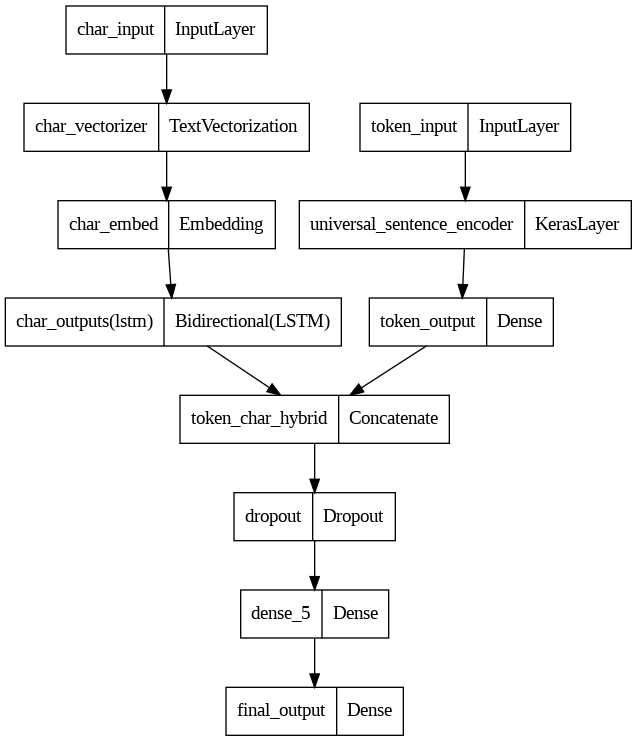

In [69]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [70]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a `tf.data` dataset

the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a `tf.data.Dataset` with a tuple as it's first input, for example:
* `((token_data, char_data), (label))`
1. First : 'concatenate' `token_data` and `char_data` by creating a Dataset using `tf.data.Dataset.from_tensor_slices`
1. Secondly : create a Dataest for the label using `tf.data.Dataset.from_tensor_slices`
1. Thirdly : Zip the two previous Dataset using `tf.data.Dataset.zip`

> **Reminder :**
<br>
* token_data is sentense -> `train_sentences` -> `train_dataset`
* char_data is character -> `train_chars` -> `train_char_dataset`
* label stay the same -> `train_labels_one_hot`



In [71]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(100).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(100).prefetch(tf.data.AUTOTUNE)

# Repeat same steps testing data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(100).prefetch(tf.data.AUTOTUNE)

### Fitting model

In [72]:
history_4 = model_4.fit(train_char_token_dataset,
                        steps_per_epoch=int(0.3 * len(train_char_token_dataset)),
                        epochs=3,
                        validation_data=val_char_token_dataset,
                        validation_steps=int(0.1*len(val_char_token_dataset)))

# Warning : when specify `steps_per_epoch` you need :
# steps_per_epoch * epochs > len(dataset) (depending of the nb of batch)

Epoch 1/3
540/540 [==============================] - 25s 39ms/step - loss: 0.8641 - accuracy: 0.6608 - val_loss: 0.7184 - val_accuracy: 0.7237
Epoch 2/3
540/540 [==============================] - 22s 41ms/step - loss: 0.7394 - accuracy: 0.7174 - val_loss: 0.6606 - val_accuracy: 0.7463
Epoch 3/3
540/540 [==============================] - 20s 38ms/step - loss: 0.6980 - accuracy: 0.7331 - val_loss: 0.6406 - val_accuracy: 0.7577


In [73]:
preds_4 = np.argmax(model_4.predict(test_char_token_dataset), axis=1)

302/302 [==============================] - 8s 24ms/step


In [74]:
scores_4 = evaluate(test_labels_encoded, preds_4)
compare_to_baseline(baseline_scores, scores_4)

Baseline accuracy: 0.72, --------New accuracy: 0.75, -----Difference: 2.33%
Baseline precision: 0.72, -------New precision: 0.75, -----Difference: 2.92%
Baseline recall: 0.72, ----------New recall: 0.75, -----Difference: 2.33%
Baseline f1_score: 0.70, --------New f1_score: 0.74, -----Difference: 4.13%


## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings 

What if we engineered our own features into the model?
<br>
Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called **feature engineering**.

Can you think of something important about the sequences we're trying to classify?

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled `CONCLUSIONS` at the beggining and sequences labelled `OBJECTIVE` at the end?

Abstracts typically come in a sequential order, such as:
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...

Or

* `BACKGROUND` ...
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...
* `CONCLUSIONS` ...

Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,
* `Sentence 1 of 10` ...
* `Sentence 2 of 10` ...
* `Sentence 3 of 10` ...
* `Sentence 4 of 10` ...
* ...


You might've noticed this when we created our `preprocess_text()` function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the `"line_number"` and `"total_lines"` columns of our DataFrames.

In [75]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


The `"line_number"` and `"total_lines"` columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**. In other words, the positional embedding is where the sentence appears in an abstract.

We can use these features because they will be available at test time. 

![example of engineering features into our dataset to help our model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-engineered-features-at-test-time.png)
*Since abstracts typically have a sequential order about them (for example, background, objective, methods, results, conclusion), it makes sense to add the line number of where a particular sentence occurs to our model. The beautiful thing is, these features will be available at test time (we can just count the number of sentences in an abstract and the number of each one).*

Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

> 🛠 **Exercise:** Another way of creating our positional embedding feature would be to combine the `"line_number"` and `"total_lines"` columns into one, for example a `"line_position"` column may contain values like `1_of_11`, `2_of_11`, etc. Where `1_of_11` would be the first line in an abstract 11 sentences long. After going through the following steps, you might want to revisit this positional embedding stage and see how a combined column of `"line_position"` goes against two separate columns.

### Create positional embeddings

Since our `"line_number"` and `"total_line"` columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with `"line_number"=5` is five times greater than a line with `"line_number"=1`, we'll use one-hot-encoding to encode our `"line_number"` and `"total_lines"` features.

To do this, we can use the [`tf.one_hot`](https://www.tensorflow.org/api_docs/python/tf/one_hot) utility.

`tf.one_hot` returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the `depth` parameter determines the dimension of the returned tensor.

To figure out what we should set the `depth` parameter to, let's investigate the distribution of the `"line_number"` column.

> 🔑 **Note:** When it comes to one-hot-encoding our features, Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) class is another viable option here.

In [76]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

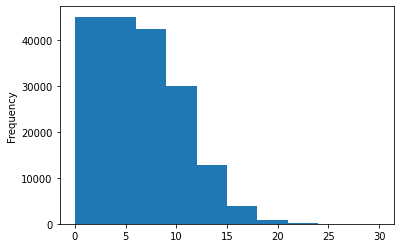

In [77]:
train_df.line_number.plot.hist(bins=10)

In [78]:
line_number = train_df.line_number
line_number_depth = int(np.percentile(line_number, 95)) # 13 

In [79]:
train_line_number = tf.one_hot(train_df.line_number.to_numpy(), depth=line_number_depth)
val_line_number = tf.one_hot(val_df.line_number.to_numpy(), depth=line_number_depth)
test_line_number = tf.one_hot(test_df.line_number.to_numpy(), depth=line_number_depth)

In [80]:
train_line_number[:3], train_line_number.shape

(<tf.Tensor: shape=(3, 13), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 13]))

Setting the `depth` parameter of `tf.one_hot` to 15 means any sample with a `"line_number"` value of over 15 gets set to a tensor of all 0's, where as any sample with a `"line_number"` of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the `"line_number"` value.


In [81]:
train_df.total_lines.value_counts().sort_index()

4        32
5       215
6      1146
7      3353
8      7464
9     12285
10    19400
11    23639
12    24468
13    22113
14    18438
15    14610
16    10768
17     7429
18     5202
19     3344
20     2480
21     1281
22      770
23      759
24      264
25      200
26      182
27       81
28       28
29       58
31       31
Name: total_lines, dtype: int64

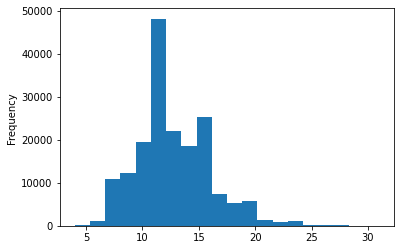

In [82]:
train_df.total_lines.plot.hist(bins=20)

In [83]:
total_lines_depth = int(np.percentile(train_df.total_lines, 95)) #19

In [84]:
train_total_lines = tf.one_hot(train_df.total_lines.to_numpy(), depth=total_lines_depth)
val_total_lines = tf.one_hot(val_df.total_lines.to_numpy(), depth=total_lines_depth)
test_total_lines = tf.one_hot(test_df.total_lines.to_numpy(), depth=total_lines_depth)

### Building a tribrid embedding model

We're going to go through the following steps:

1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Create a `"line_number"` model (takes in one-hot-encoded `"line_number"` tensor and passes it through a non-linear layer)
4. Create a `"total_lines"` model (takes in one-hot-encoded `"total_lines"` tensor and passes it through a non-linear layer)
5. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf)
6. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding 
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [114]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
x = hub_embedding(token_inputs)
token_outputs = layers.Dense(128, activation="relu", name="token_output")(x)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")

# 2. char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
x = text_vectorizer(char_inputs)
x = char_embed(x)
char_outputs = layers.Bidirectional(layers.LSTM(32))(x)
char_model = tf.keras.Model(char_inputs, char_outputs, name="char_model")

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(line_number_depth,), dtype=tf.int32, name="line_number_inputs")
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs, name="line_number_model")

# 4. Total line inputs
total_line_inputs = layers.Input(shape=(total_lines_depth,), dtype=tf.int32, name="total_line_inputs")
total_line_outputs = layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_outputs, name="total_line_model")

# 5. Combine token ans char embeddings into a hybrid embedding
combined_embedding = layers.Concatenate(name="token_char_embedding")([token_model.output, char_model.output])
x = layers.Dense(256, activation="relu")(combined_embedding)
combined_embedding_dropout = layers.Dropout(0.5)(x)

# 6. Combine total_line and line_number model and combined_embedding_dropout
final_concat = layers.Concatenate(name="final_concat")([combined_embedding_dropout,
                                                        line_number_model.output,
                                                        total_line_model.output])
# 7. Create output layer
outputs_layer = layers.Dense(num_classes, activation="softmax", name="outputs_layer")(final_concat)

# 8. Create the final model : model_5
model_5 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 line_number_model.input,
                                 total_line_model.input],
                         outputs=outputs_layer,
                         name="model_5")


In [115]:
model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['char_inputs[0][0]']            
 ization)                                                                                         
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

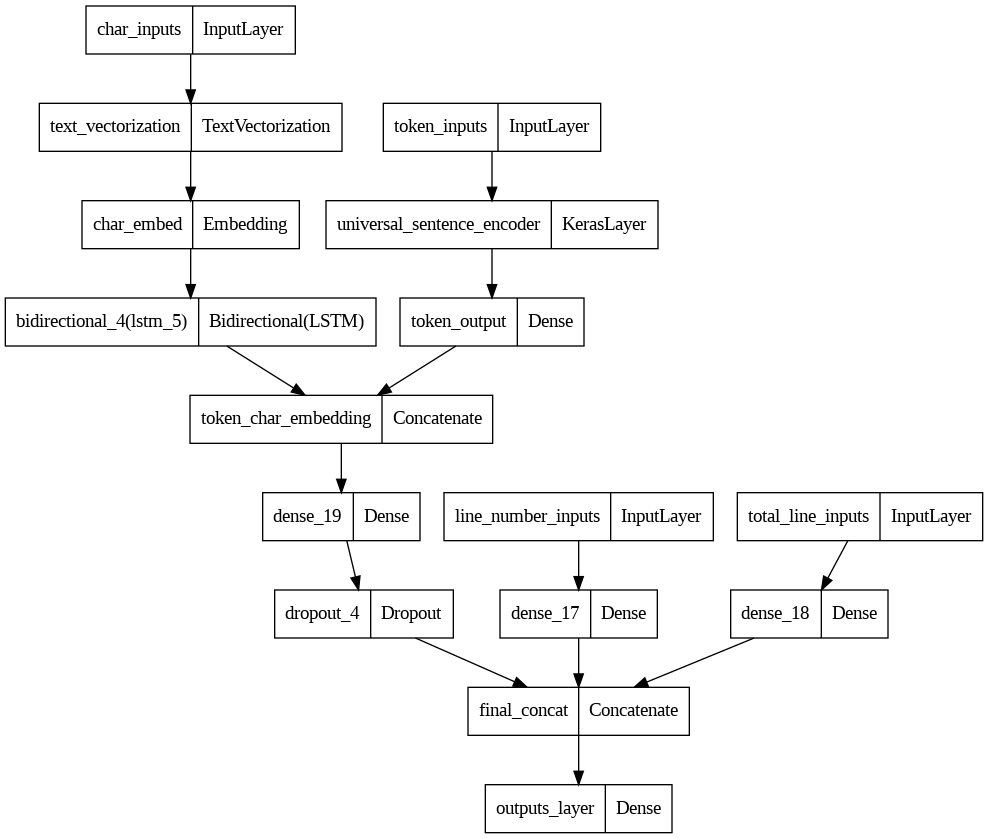

In [116]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

### Create Dataset

Must match the order of inputs in the model : 

e.g. :

If
```
model_5 = tf.keras.Model(inputs=[model_1.input,
                                 model_2.input,
                                 model_3.input,
                                 model_4.input],
                         outputs=outputs_layer,
                         name="model_5")
```
Then the Dataset should be :
```
train_data = tf.data.Dataset.from_tensor_slices((data_1,
                                                data_2
                                                data_3,
                                                data_4))

train_label = tf.data.Dataset.from_tensor_slices(label)

train_dataset = tf.data.Dataset.zip((train_data, train_label))
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
```

> **Reminder :**
<br>
* token_data is sentense -> `train_sentences`
* char_data is character -> `train_chars` 
* number_line -> `train_line_number`
* total_line -> `train_total_lines`
* label stay the same -> `train_labels_one_hot`

In [117]:
train_inputs_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                           train_chars,
                                                           train_line_number,
                                                           train_total_lines))
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset_5 = tf.data.Dataset.zip((train_inputs_dataset, train_labels_dataset))
train_dataset_5 = train_dataset_5.batch(64).prefetch(tf.data.AUTOTUNE)


val_inputs_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                         val_chars,
                                                         val_line_number,
                                                         val_total_lines))
val_labels_dataset = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset_5 = tf.data.Dataset.zip((val_inputs_dataset, val_labels_dataset))
val_dataset_5 = val_dataset_5.batch(64).prefetch(tf.data.AUTOTUNE)


test_inputs_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,
                                                          test_chars,
                                                          test_line_number,
                                                          test_total_lines))
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset_5 = tf.data.Dataset.zip((test_inputs_dataset, test_labels_dataset))
test_dataset_5 = test_dataset_5.batch(64).prefetch(tf.data.AUTOTUNE)

In [118]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [127]:
history_5 = model_5.fit(train_dataset_5,
                        epochs=3,
                        validation_data=val_dataset_5,
                        validation_steps=int(0.1 * len(val_dataset_5)))

Epoch 1/3
2814/2814 [==============================] - 59s 21ms/step - loss: 0.9146 - accuracy: 0.8497 - val_loss: 0.9064 - val_accuracy: 0.8484
Epoch 2/3
2814/2814 [==============================] - 59s 21ms/step - loss: 0.9029 - accuracy: 0.8576 - val_loss: 0.9031 - val_accuracy: 0.8504
Epoch 3/3
2814/2814 [==============================] - 58s 21ms/step - loss: 0.8945 - accuracy: 0.8638 - val_loss: 0.9037 - val_accuracy: 0.8484


In [128]:
preds_5 = np.argmax(model_5.predict(test_dataset_5), axis=1)

471/471 [==============================] - 7s 15ms/step


In [129]:
scores_5 = evaluate(test_labels_encoded, preds_5)
compare_to_baseline(baseline_scores, scores_5)

Baseline accuracy: 0.72, --------New accuracy: 0.85, -----Difference: 12.47%
Baseline precision: 0.72, -------New precision: 0.85, -----Difference: 12.77%
Baseline recall: 0.72, ----------New recall: 0.85, -----Difference: 12.47%
Baseline f1_score: 0.70, --------New f1_score: 0.84, -----Difference: 14.45%


## Compare model results 

In [130]:
all_model_results = pd.DataFrame({"baseline": baseline_scores,
                                  "custom_token_embed_conv1d": scores_1,
                                  "pretrained_token_embed": scores_2,
                                  "custom_char_embed_conv1d": scores_3,
                                  "hybrid_char_token_embed": scores_4,
                                  "tribrid_pos_char_token_embed": scores_5})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1_score
baseline,0.721832,0.718647,0.721832,0.698925
custom_token_embed_conv1d,0.796748,0.793422,0.796748,0.794384
pretrained_token_embed,0.748565,0.745320,0.748565,0.744399
custom_char_embed_conv1d,0.368177,0.242674,0.368177,0.263267
hybrid_char_token_embed,0.745147,0.747878,0.745147,0.740266
tribrid_pos_char_token_embed,0.846491,0.846379,0.846491,0.843441


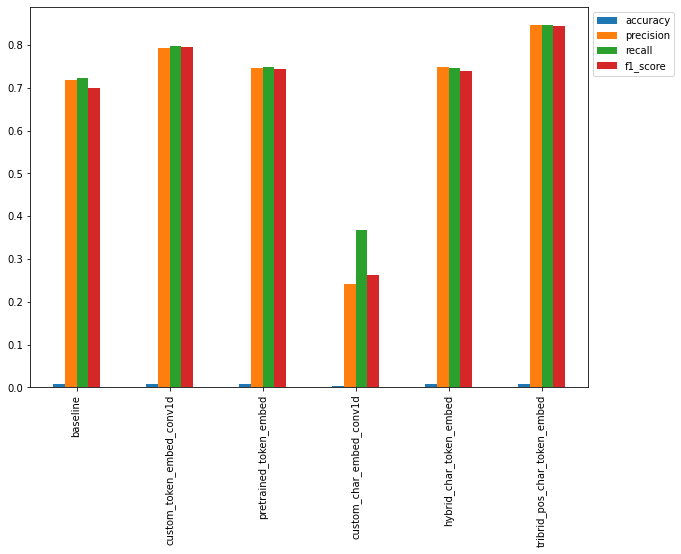

In [131]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

## Save and load best performing model

In [132]:
model_5.save("skimlit_tribrid_model")